# Quasi-continuous BN

| | | |
|-|-|-|
|[ ![Creative Commons License](images/cc4.png)](http://creativecommons.org/licenses/by-nc/4.0/) |[ ![aGrUM](images/logoAgrum.png)](https://agrum.org) |[ ![interactive online version](images/atbinder.svg)](https://agrum.gitlab.io/extra/agrum_at_binder.html)

aGrUM cannot (currently) deal with with continuous variables. However, a discrete variable with a large enough domain size is an approximation of such variables.

In [1]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

#nbr of states for quasi continuous variables. You can change the value 
#but be careful of the quadratic behavior of both memory and time complexity
#in this example.
minB,maxB=-3,3
minC,maxC=4,14
NB=200 

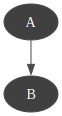

In [2]:
# the line with fastBN replace the commented ones.
#bn=gum.BayesNet()
#bn.add(gum.LabelizedVariable("A","A binary variable",2))
#bn.add(gum.NumericalDiscreteVariable("B","A range variable",minB,maxB,NB))
#bn.addArc("A","B")
bn=gum.fastBN(f"A[3]->B[{minB}:{maxB}:{NB}]")

gnb.showBN(bn)

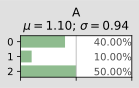

In [3]:
bn.cpt("A")[:]=[0.4, 0.1,0.5]
gnb.showProba(bn.cpt("A"))

## CPT for quasi-continuous variables (with parents)

Using python (and scipy), it is easy to find pdf for continuous variable


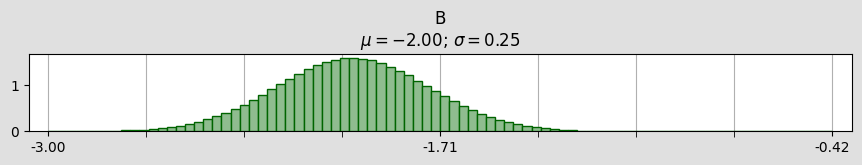
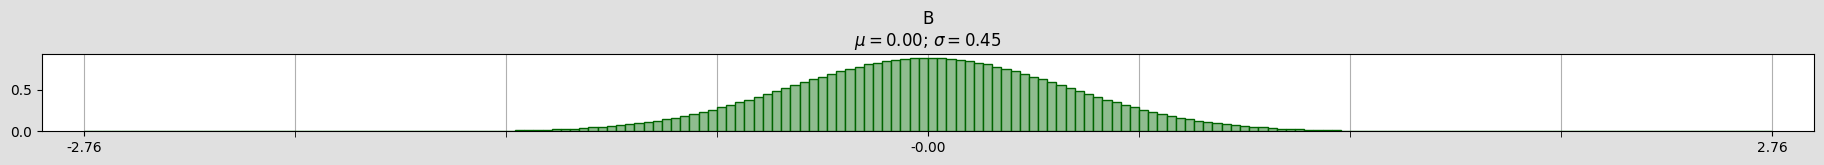
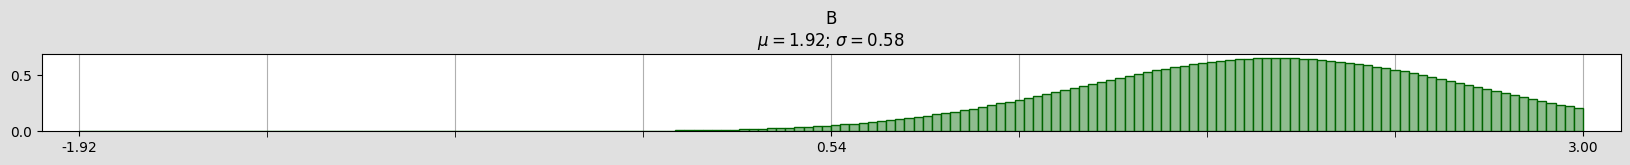

In [4]:
from scipy.stats import norm,genhyperbolic

bn.cpt("B").fillFromDistribution(norm,loc="-2+A*2",scale="(5+A*4)/20")

gnb.flow.clear()
gnb.flow.add(gnb.getProba(bn.cpt("B").extract({"A":0})),caption="P(B|A=0)")
gnb.flow.add(gnb.getProba(bn.cpt("B").extract({"A":1})),caption="P(B|A=1)")
gnb.flow.add(gnb.getProba(bn.cpt("B").extract({"A":2})),caption="P(B|A=1)")
gnb.flow.display()

## Quasi-continuous inference (with no evidence)

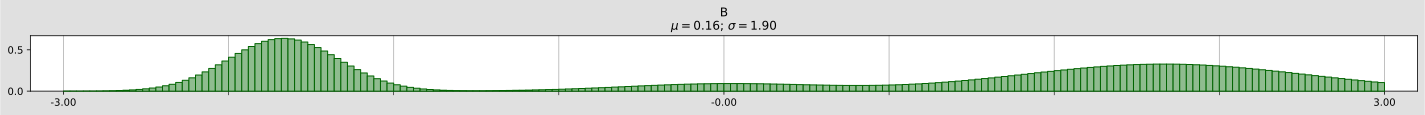

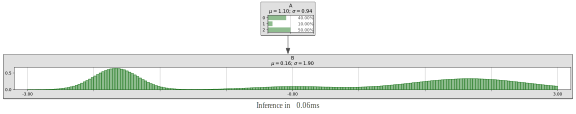

In [5]:
gnb.showPosterior(bn,target="B",evs={})
gnb.showInference(bn)

## Quasi-continuous inference with numerical evidence expressed as logical propositions `evEq` or `evIn`,`evLt`, `evGt`; and boolean operators

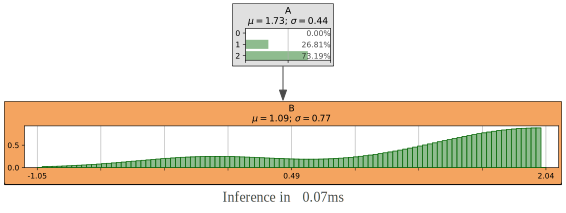

In [6]:
gnb.showInference(bn,evs=[bn.evIn("B",-1,2)]) # we observed B between -1 and 2

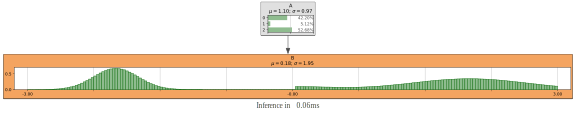

In [7]:
gnb.showInference(bn,evs=[~ bn.evIn("B",-1,0)]) # we observed B not being between -1 and 0

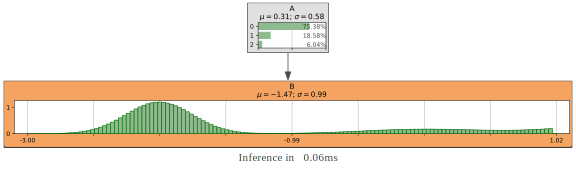

In [8]:
gnb.showInference(bn,evs=[bn.evLt("B",1)]) # we observed B being less than 1

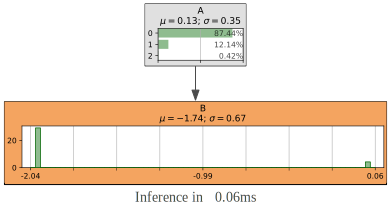

In [9]:
gnb.showInference(bn,evs=[bn.evEq("B",0) | 
                          bn.evEq("B",-2)]) # we observed B being -1 or 2

## Quasi-continuous variable with quasi-continuous parent

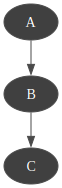

In [10]:
bn=gum.fastBN("A[3]->B->C",
       f"[{minB}:{maxB}:{NB}]") # default type of variables (for B and C)
gnb.showBN(bn) # B and C are quasi-continouous

Even if this BN is quite small (and linear), the size of nodes $B$ et $C$ are rather big and creates a complex model (NBxNB parameters in $P(C|B)$).

In [11]:
print("nombre de paramètres du bn : {0}".format(bn.dim()))
print("domaine du bn : 10^{0}".format(bn.log10DomainSize()))

nombre de paramètres du bn : 40399
domaine du bn : 10^5.079181246047625



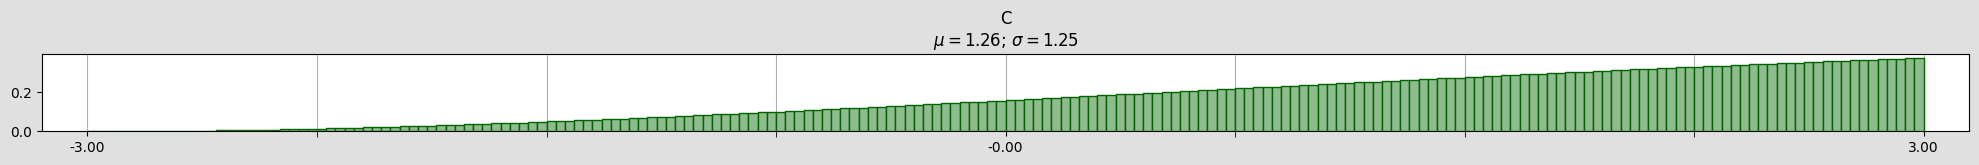
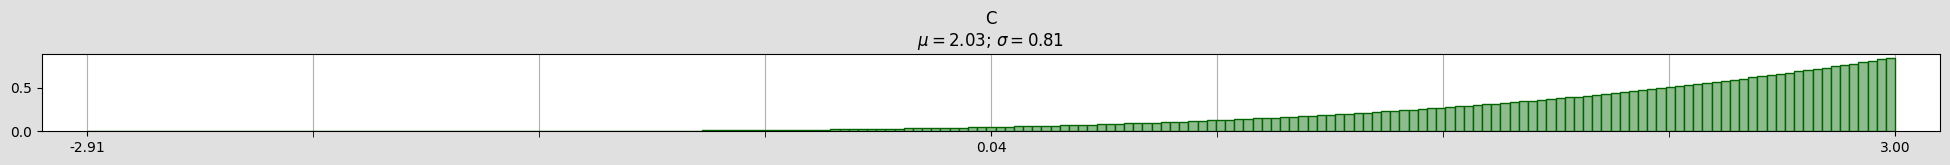
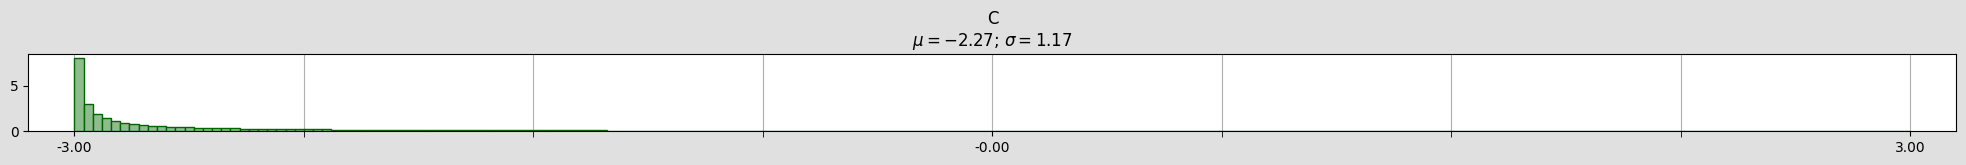

In [12]:
from scipy.stats import gamma

bn.cpt("B").fillFromDistribution(norm,loc="-2+A*2",scale="(5+A*4)/20")
bn.cpt("C").fillFromDistribution(gamma,a="B+3.1",loc=-3,scale=5)

def showCgivenBequals(x:float):
    gnb.flow.add(gnb.getProba(bn.cpt("C").extract({"B":f"{x}"})),
                 caption=f"P(C|B={x})")
gnb.flow.clear()
showCgivenBequals(0)
showCgivenBequals(3)
showCgivenBequals(-3)
#showB(NB-1)
gnb.flow.display()

### Inference in quasi-continuous BN


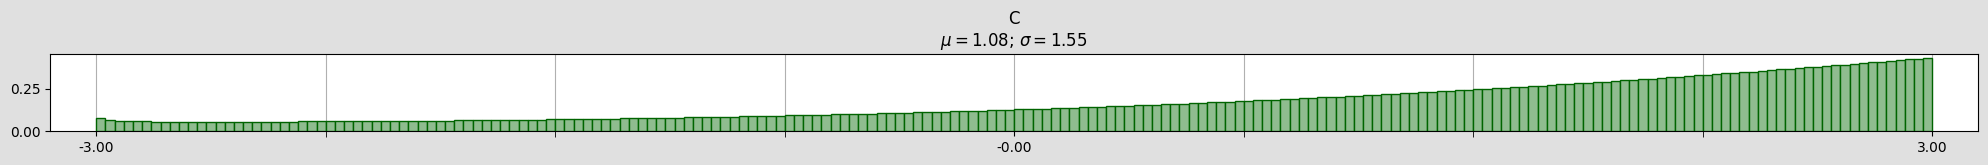

In [13]:
import time

ts = time.time()
ie=gum.LazyPropagation(bn)
ie.makeInference()
q=ie.posterior("C")
te=time.time()
gnb.flow.add(gnb.getPosterior(bn,target="C",evs={}),caption=f"P(C) computed in {te-ts:2.5f} sec for a model with {bn.dim()} parameters")
gnb.flow.display()


## Changing prior

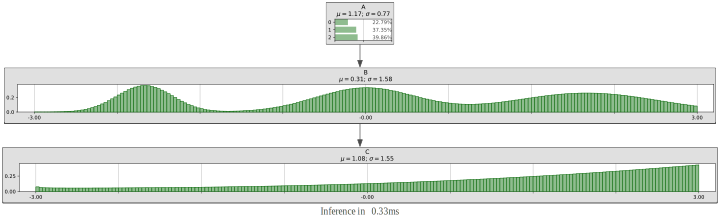

In [14]:
gnb.showInference(bn,size="10")

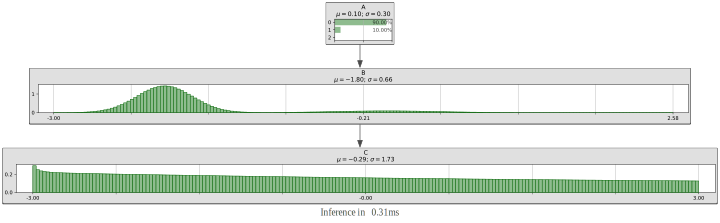

In [15]:
bn.cpt("A")[:]=[0.9,0.1,0.0]
             
gnb.showInference(bn,size="10")

## inference with evidence in quasi-continuous BN

We want to compute 
<ul><li>
$P(A | C=3)$ 
</li><li>
$P(B | C=3)$
</li></ul>

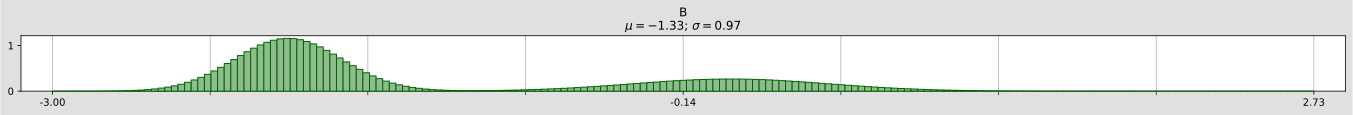

In [16]:
ie=gum.LazyPropagation(bn)
ie.setEvidence([bn.evEq("C",3)])
ie.makeInference()
gnb.showProba(ie.posterior("B"))

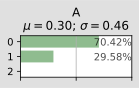

In [17]:
gnb.showProba(ie.posterior("A"))

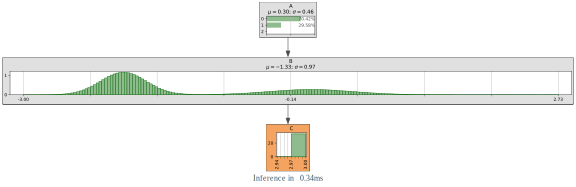

In [18]:
gnb.showInference(bn,evs=[bn.evEq("C",3)])

## Multiple inference : MAP DECISION between complex distributions

What is the behaviour of $P(A | C=i)$&nbsp;&nbsp; when $i$ varies ? I.e. we perform a MAP decision between the two models ($A=0$&nbsp; for the Gaussian distribution and $A=1$&nbsp; for the generalized hyperbolic  distribution).

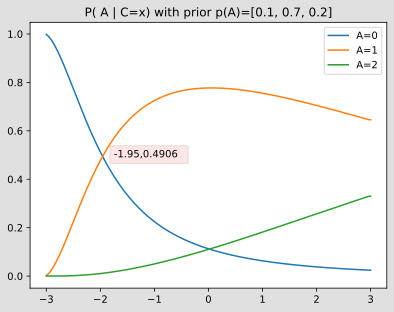




  DECISION RULE : If C<-1.950 Then A=0 else A=1


In [19]:
import matplotlib.pyplot as plt
import numpy as np

bn.cpt("A")[:]=[0.1, 0.7,0.2]
ie=gum.LazyPropagation(bn)
p0=[]
p1=[]
p2=[]
x=bn.variable("C").ticks()
for i in x:
    ie.setEvidence([bn.evEq("C",i)])
    ie.makeInference()    
    p0.append(ie.posterior("A")[0])    
    p1.append(ie.posterior("A")[1])
    p2.append(ie.posterior("A")[2])

plt.plot(x,p0)
plt.plot(x,p1)
plt.plot(x,p2)
plt.title(f"P( A | C=x) with prior p(A)={bn.cpt('A').tolist()}")
plt.legend(["A=0","A=1","A=2"],loc='best')
inters=(np.transpose(p0)>np.transpose(p1)).argmin()

plt.text(x[inters]+0.2,p0[inters],
     "{0:5.4},{1:5.4f}  ".format(x[inters],p0[inters]),
     bbox=dict(facecolor='red', alpha=0.1),ha='left');
plt.show()
print("\n\n")
print("==========================================================")
print(f"  DECISION RULE : If C<{x[inters]:0.3f} Then A=0 else A=1")
print("==========================================================")

### Same MAP with another $P(A)$

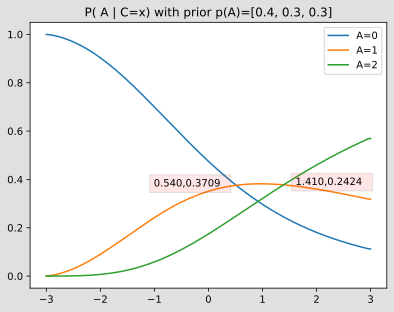




  DECISION RULE : If C<0.540 Then A=0
                  ElseIf C<1.410 Then A=1
                  Else A=2


In [20]:
bn.cpt("A").fillWith([0.4, 0.3, 0.3])
ie=gum.LazyPropagation(bn)
p0=[]
p1=[]
p2=[]
x=bn.variable("C").ticks()
for i in x:
    ie.setEvidence([bn.evEq("C",i)])
    ie.makeInference()    
    p0.append(ie.posterior("A")[0])    
    p1.append(ie.posterior("A")[1])
    p2.append(ie.posterior("A")[2])

plt.plot(x,p0)
plt.plot(x,p1)
plt.plot(x,p2)
plt.title(f"P( A | C=x) with prior p(A)={bn.cpt('A').tolist()}")
plt.legend(["A=0","A=1","A=2"],loc='best')
inters1=(np.transpose(p0)>np.transpose(p1)).argmin()
inters2=(np.transpose(p1)>np.transpose(p2)).argmin()

plt.text(x[inters1]-0.2,p0[inters1],
     "{0:5.3f},{1:5.4f}  ".format(x[inters1],p0[inters1]),
     bbox=dict(facecolor='red', alpha=0.1),ha='right');

plt.text(x[inters2]+0.2,p1[inters2],
     "{0:5.3f},{1:5.4f}  ".format(x[inters2],p0[inters2]),
     bbox=dict(facecolor='red', alpha=0.1),ha='left');

plt.show()
print("\n\n")
print("==========================================================")
print(f"  DECISION RULE : If C<{x[inters1]:0.3f} Then A=0")
print(f"                  ElseIf C<{x[inters2]:0.3f} Then A=1")
print(f"                  Else A=2")
print("==========================================================")